<a href="https://colab.research.google.com/github/SGGC2023/CP_Plan_llave_Acapulco/blob/main/capacitaci%C3%B3n_locatel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Locatel



En este bloc se describe la creación de una I.A para la clasificación y despacho de solicitudes de atención ciudadana mediante el entrenamiento de una red neuronal con arquitectura *deep learning*.


Creado por [Alejandro Molina](https://www.centrogeo.org.mx/areas-profile/amolina), 20 de enero 2022.

# STAGE 1 Preparación de datos para dos modelos: subpalabras y neuronal


In [ ]:
# montaje de unidades en la nube
from google.colab import drive
# deep learning
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
# codificación-decodificación datos textuales
from tensorflow.keras import layers
import tensorflow_datasets as tfds
# muestreo estratificado
from sklearn.model_selection import StratifiedKFold
# evaluación modelos de aprendizaje
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# resumen automático
from gensim.summarization.summarizer import summarize
# manipulación de BD, tablas, vectores y otros
import numpy as np
import pandas as pd
import math
import csv
# limpieza de datos textuales
import re

## Montaje de unidad y lectura de datos

In [ ]:
# montar drive
drive.mount('/content/drive/')
%cd'/content/drive/Shareddrives/CNNlocatel'

Mounted at /content/drive/
/content/drive/Shareddrives/CNNlocatel


In [ ]:
# leer datos crudos
cols = ["folio","fecha","tema","motivo","texto","calle","num","interior","mza","lote","colonia","alcaldia","cp","lon","lat","id_turno","dependencia"]
df = pd.read_csv("data/SUAC_0619-0921.csv",
    header=0,
    index_col=0,
    names=cols,
    engine="python",
    encoding="UTF-8",
    sep=','
)

df.head()

,fecha,tema,motivo,texto,calle,num,interior,mza,lote,colonia,alcaldia,cp,lon,lat,id_turno,dependencia
folio,,,,,,,,,,,,,,,,
1,1/6/2019,NaN,NaN,¿Donde puedo denunciar abuso sexual y violenci...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,Procuraduría General de Justicia de la Ciudad ...
1,1/6/2019,NaN,NaN,¿Donde puedo denunciar abuso sexual y violenci...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,Sistema para el Desarrollo Integral de la Fami...
2,1/6/2019,NaN,REINSCRIPCION AL CENDI,Buenas noches Sra jefa de gobierno el motivo d...,No aplica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,Jefatura de Gobierno de la Ciudad de México
2,1/6/2019,NaN,REINSCRIPCION AL CENDI,Buenas noches Sra jefa de gobierno el motivo d...,No aplica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,Secretaría del Medio Ambiente
3,2/6/2019,NaN,NaN,Estuve dentro de la CAMPAÑA que llegó a la vic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.0,Metrobús


Desde el punto de vista técnico,el problema que abordamos es la clasificación automática del motivo a partir de un campo no estructurados (texto libre). Por ejemplo, el "Solicito se pode la raíz de un árbol que está levantando la banqueta de la calle" debe clasificarse al tipo PODA. En este sentido caben algunas observaciones:


*   Los únicos atributos que nos serán de utilidad para el modelo son: folio, motivo, texto.
*   Algunos folios se duplican porque id_turno y dependencia son diferentes pero para nuestro problema, los textos duplicados no tienen relevancia (incluso perjudican).
*   No todos los registros tienen texto y esos casos no nos sirven para nada.
*   No todos los registros tienen motivo (muchos NAs) y esos casos no podemos usarlos para el entrenamiento (para otras cosas sí se usan).




In [ ]:
# eliminar columnas innecesarias
df.drop(columns=["fecha","tema","calle","num","interior","mza","lote","colonia","alcaldia","cp","lon","lat","id_turno","dependencia"], inplace=True)
# eliminar folio duplicado (índice)
df = df[~df.index.duplicated(keep='first')]
# eliminar NAs en texto
df.dropna(subset=['texto'], inplace=True)
# Guardar dfs para el modelo de subpalabras y sin motivo
df_para_subpals =df
df_sin_motivo = df[df['motivo'].isnull()]

df.head()


,motivo,texto
folio,,
1,NaN,¿Donde puedo denunciar abuso sexual y violenci...
2,REINSCRIPCION AL CENDI,Buenas noches Sra jefa de gobierno el motivo d...
3,NaN,Estuve dentro de la CAMPAÑA que llegó a la vic...
4,NaN,Violencia a menores de edad ya envié la inform...
5,NaN,EStos niños están siendo abusados por su propi...


## Análisis de la distribución de las clases (motivo)


In [ ]:
# registros no tienen motivo
print('SIN MOTIVO:',df_sin_motivo.size)

# Al usar los datos y agruparlos por motivo se obtienen la siguiente distribución
# de solicitudes en las 48 clases distintas.
# Es importante mencionar que esto se hizo sin considerar inconsistencias o irregularidades en el campo de texto
# (las cuales se tratarán adelante).

#El desbalance es muy notorio pero el volumen de datos es importante,
# se estima que un modelo de redes neuronales podría resultar bien siempre
# y cuando se tenga en cuenta un muestreo estratificado y se codifique de manera adecuada con
# word embeddings de dominio específico.

# En este momento no sabemos hasta que punto nos afecta el desbalance hasta no tener un primer
# modelo evaluado con métricas de ML.

print(df.groupby(by='motivo').size())

SIN MOTIVO: 502936
motivo
ALARMAS VECINALES                              530
ALERTA SISMICA                               27317
ALUMBRADO                                   121697
APOYO SERVICIOS FUNERARIOS                     218
ASESORÍA DE TERCEROS ACREDITADOS               407
ASESORÍA JURÍDICA                             1103
ASISTENCIA SOCIAL                             1418
ASISTENCIA VETERINARIA                         647
BACHEO                                       35578
BALIZAMIENTO                                  4215
BARBECHO / CHAPONEO                           6418
BECAS                                         2633
COVID                                        37654
CRÉDITO DE VIVIENDA                           3511
DESAZOLVE                                    42455
FALTA DE AGUA                                79714
FUGA DE AGUA                                 57417
LIMPIEZA VIA PUBLICA                          2940
LLAVE CDMX                                    2119
MANTE

## Análisis de la distribución de longitudes (núm de chars)

count    1.073093e+06
mean     2.329731e+02
std      2.287514e+02
min      1.000000e+00
25%      8.300000e+01
50%      1.590000e+02
75%      2.980000e+02
max      5.733000e+03
Name: texto, dtype: float64

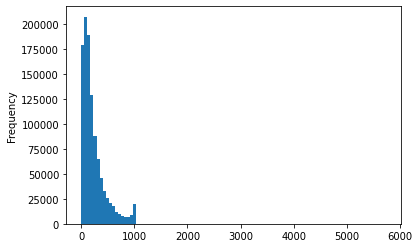

In [ ]:
df['texto'].apply(lambda x: len(x)).plot.hist(bins=100)
df['texto'].apply(lambda x: len(x)).describe()

In [ ]:
# Problema con la extensión de los textos hay algunos demasiado cortos y otros demasiado largos.

#Regularización de la extensión textual mediante algoritmo de resúmen automático TextRank.

# "Summarizing is based on ranks of text sentences using a variation of the TextRank algorithm"
# Federico Barrios, Federico L´opez, Luis Argerich, Rosita Wachenchauzer (2016).
# Variations of the Similarity Function of TextRank for Automated Summarization,
# https://arxiv.org/abs/1602.03606

# TextRank
# https://radimrehurek.com/gensim_3.8.3/summarization/summariser.html

def textrank(d, maxlen=1000):
    d = d+"." if not d.endswith(".") else d
    if len(d) < maxlen:
        s = d
    else:
        try:
            s = summarize(d)
        except:
            s = ' '.join(d.split())[:maxlen]
        if len(s) > maxlen:
            s = ' '.join(s.split())[:maxlen]
    return s

df['resumen'] = df['texto'].apply(lambda x: textrank(x))


count    1.073093e+06
mean     2.282373e+02
std      2.127097e+02
min      0.000000e+00
25%      8.300000e+01
50%      1.580000e+02
75%      2.950000e+02
max      1.000000e+03
Name: resumen, dtype: float64

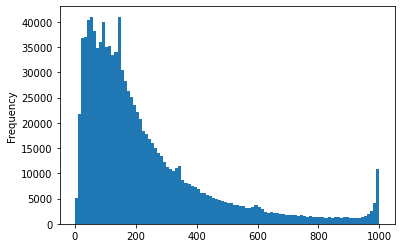

In [ ]:
df['resumen'].apply(lambda x: len(x)).plot.hist(bins=100)
df['resumen'].apply(lambda x: len(x)).describe()

In [ ]:
df= df.dropna(subset=['motivo'])
df= df.dropna(subset=['resumen'])

df.head()

,motivo,texto,resumen
folio,,,
2,REINSCRIPCION AL CENDI,Buenas noches Sra jefa de gobierno el motivo d...,Buenas noches Sra jefa de gobierno el motivo d...
6,BARBECHO / CHAPONEO,ABUSO SEXUAL Y MALTRATO INFANTIL Mi nombre es ...,
9,BACHEO,"Hay varios Baches en la Calle de Venus, entre ...","Hay varios Baches en la Calle de Venus, entre ..."
10,VENTA DE ALCOHOL / DROGA,Hay un grupo de chavos viciosos que diario y a...,Aquí pasan muchas patrullas a toda hora porque...
11,USO DE SUELO,Quiero conocer el estatus de uso de suelo del ...,Quiero conocer el estatus de uso de suelo del ...


## Preprocesamiento del texto de la descripción (resumen)

In [ ]:
# Homogenizar el texto para optimizar los resultados
# usando un pre-procesamiento básico, el cual incluye:
# remoción de números, texto a minúsculas, remoción URLs básica
# remoción de caracteres de espacios.
# IMPORTANTE: Se DEBE usar la misma función de limpieza
# tanto en el entrenamiento como en la evaluación de la red.

def clean_text(text):
    # Removing numbers
    text = re.sub(r'[0-9]+', '', text)
    # all lower case
    text = text.lower()
    # Removing the URL links
    text = re.sub(r'https?:\/\/.*', '', text)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub(r'[^\w\s]+', '', text,re.UNICODE)
    # Removing additional whitespaces
    text = re.sub(r" +", ' ', text)
    text = text.lstrip().rstrip()
    return text

In [ ]:
# preprocesar texto para el modelo de subpalabras
df_para_subpals['text_clean']=[clean_text(t) for t in df_para_subpals.resumen]
df_para_subpals=df_para_subpals.dropna(subset=['text_clean'])
# preprocesar texto para el modelo de red neuronal
df['text_clean']=[clean_text(t) for t in df.resumen]
df= df.dropna(subset=['text_clean'])

df.head()

,motivo,texto,resumen,text_clean
folio,,,,
2,REINSCRIPCION AL CENDI,Buenas noches Sra jefa de gobierno el motivo d...,Buenas noches Sra jefa de gobierno el motivo d...,buenas noches sra jefa de gobierno el motivo d...
6,BARBECHO / CHAPONEO,ABUSO SEXUAL Y MALTRATO INFANTIL Mi nombre es ...,,
9,BACHEO,"Hay varios Baches en la Calle de Venus, entre ...","Hay varios Baches en la Calle de Venus, entre ...",hay varios baches en la calle de venus entre p...
10,VENTA DE ALCOHOL / DROGA,Hay un grupo de chavos viciosos que diario y a...,Aquí pasan muchas patrullas a toda hora porque...,aquí pasan muchas patrullas a toda hora porque...
11,USO DE SUELO,Quiero conocer el estatus de uso de suelo del ...,Quiero conocer el estatus de uso de suelo del ...,quiero conocer el estatus de uso de suelo del ...


## Generación de diccionario de etiquetas de clase


In [ ]:
# Asignar un número entero como identificador de cada una de las clases.
# IMPORTANTE: Usar el mismo número durante entrenamiento, evaluación y pruebas.

data_labels = df.motivo.values
label_dict = {motivo:i for i, motivo in  enumerate(sorted(set(data_labels)))}
nclasses = len(set(data_labels))
print(nclasses)
print(label_dict)

df['label'] = [label_dict[x] for x in df.motivo.values]

id_labels=pd.DataFrame.from_dict(label_dict,orient='index', columns=['motivo'])

# conteo de frecuencias de clase
groups = df.groupby('label')
g = groups.size()

48
{'ALARMAS VECINALES': 0, 'ALERTA SISMICA': 1, 'ALUMBRADO': 2, 'APOYO SERVICIOS FUNERARIOS': 3, 'ASESORÍA DE TERCEROS ACREDITADOS': 4, 'ASESORÍA JURÍDICA': 5, 'ASISTENCIA SOCIAL': 6, 'ASISTENCIA VETERINARIA': 7, 'BACHEO': 8, 'BALIZAMIENTO': 9, 'BARBECHO / CHAPONEO': 10, 'BECAS': 11, 'COVID': 12, 'CRÉDITO DE VIVIENDA': 13, 'DESAZOLVE': 14, 'FALTA DE AGUA': 15, 'FUGA DE AGUA': 16, 'LIMPIEZA VIA PUBLICA': 17, 'LLAVE CDMX': 18, 'MANTENIMIENTO DE COLADERA / ALCANTARILLA': 19, 'MANTENIMIENTO DRENAJE': 20, 'MANTENIMIENTO PARQUE / AREA VERDE': 21, 'MANTENIMIENTO SEMÁFOROS': 22, 'MANTENIMIENTO VÍA PÚBLICA': 23, 'PAVIMENTACION': 24, 'PODA / RETIRO ARBOL': 25, 'PROGRAMA APOYO A CUIDADORES': 26, 'PROTECCION CIVIL': 27, 'QUEJA DE TRANSPORTE PUBLICO': 28, 'QUEJA FUNCIONARIO': 29, 'RECOLECCIÓN BASURA': 30, 'REGISTRO FERIAS INDIGENAS': 31, 'REINSCRIPCION AL CENDI': 32, 'REPARACION DE EMPEDRADO': 33, 'RETIRO AMBULANTE': 34, 'RETIRO CASCAJO, ESCOMBRO, AZOLVE, RAMAS': 35, 'SOLICITU DE AUDIENCIA': 36, '

## Almacenamiento de datos preprocesados y diccionario de etiquetas de clase

In [ ]:
# Salvar los resultados hasta el momento para no tener que repetir toda la preparación.

id_labels.to_csv('data/label_dict.csv',
          sep='\t',
          encoding='utf-8',
          index=True)

g.to_csv('data/motivo_freq_clase.csv',
         sep='\t',
         encoding='utf-8',
         quotechar='"',
         quoting=csv.QUOTE_NONNUMERIC)

# eliminar duplicados
df = df.drop_duplicates(subset=['label', 'text_clean'], keep='first')

df.to_csv('data/prepro_suac.csv',
          sep='\t',
          encoding='utf-8',
          index=True,
          quotechar='"',
          quoting=csv.QUOTE_NONNUMERIC)

df_para_subpals.to_csv('data/subpals_train_suac.csv',
          sep='\t',
          encoding='utf-8',
          index=True,
          quotechar='"',
          quoting=csv.QUOTE_NONNUMERIC)

df_sin_motivo.to_csv('data/sin_motivo_suac.csv',
          sep='\t',
          encoding='utf-8',
          index=True,
          quotechar='"',
          quoting=csv.QUOTE_NONNUMERIC)

# STAGE 2 Generación de modelo de subpalabras con algoritmo Byte Pair Encoding (BPE)

In [ ]:
# carga de datos preprocesados
df = pd.read_csv("data/prepro_suac.csv",
    engine="python",
    encoding="UTF-8",
    sep='\t')

# carga de diccionario de clases
id_labels = pd.read_csv('data/label_dict.csv',
    engine="python",
    encoding="UTF-8",
    sep='\t')

# carga de conteos de instancias por clase
counts_class = pd.read_csv('data/motivo_freq_clase.csv',
    engine="python",
    encoding="UTF-8",
    sep='\t')

# carga de df para modelo de subpalabras
df_para_subpals=pd.read_csv('data/subpals_train_suac.csv',
    engine="python",
    encoding="UTF-8",
    sep='\t')

In [ ]:
# remoción de na
df= df.dropna(subset=['text_clean'])
np.where(pd.isnull(df))

df_para_subpals= df_para_subpals.dropna(subset=['text_clean'])
np.where(pd.isnull(df_para_subpals))

df_para_subpals.head()

,folio,motivo,texto,resumen,text_clean
0,1,NaN,¿Donde puedo denunciar abuso sexual y violenci...,¿Donde puedo denunciar abuso sexual y violenci...,donde puedo denunciar abuso sexual y violencia...
1,2,REINSCRIPCION AL CENDI,Buenas noches Sra jefa de gobierno el motivo d...,Buenas noches Sra jefa de gobierno el motivo d...,buenas noches sra jefa de gobierno el motivo d...
2,3,NaN,Estuve dentro de la CAMPAÑA que llegó a la vic...,Estuve dentro de la CAMPAÑA que llegó a la vic...,estuve dentro de la campaña que llegó a la vic...
3,4,NaN,Violencia a menores de edad ya envié la inform...,Violencia a menores de edad ya envié la inform...,violencia a menores de edad ya envié la inform...
4,5,NaN,EStos niños están siendo abusados por su propi...,EStos niños están siendo abusados por su propi...,estos niños están siendo abusados por su propi...


## Generación de encoder/decoder basado en subpalabras

In [ ]:
# ATENCIÓN -> Carga desde archivos evitará tiempos largos de entrenamiento
subpal_path= 'data/subpal_encoder'

# PARÁMETRIZACIÓN MODELO SUBPALS BPE
SIZE_VOCAB = 2**14
MAXSUBWORD_LEN = 4

# Construir un modelo de subpalabras desde cero
#subpal_encoder = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#    df_para_subpals.text_clean,
#    target_vocab_size=SIZE_VOCAB,
#    max_subword_length=MAXSUBWORD_LEN
#)
#subpal_encoder.save_to_file(subpal_path)

# Usar modelo entrenado cargándolo desde un archivo (pre-entrenado)
subpal_encoder = tfds.deprecated.text.SubwordTextEncoder.load_from_file(subpal_path)


# STAGE 3 Preparación de in/out para Redes Neuronales


## Codificación de inputs en subpals

In [ ]:
data_inputs = [subpal_encoder.encode(text) for text in df.text_clean]

## Padding

In [ ]:
# MAX_LEN es la máxima longitud pero en número de subpalabras dado que data_inputs
# ya fue previamente codificado en subpalabras usando el modelo pre-entrenado

MAX_LEN = max([len(text) for text in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)
print(MAX_LEN)

334


# STAGE 4 Convolutional Neural Network (CNN)

## Definición de la arquitectura modelo Convolutional Neural Network (CNN)

In [ ]:
class DCNN(tf.keras.Model):

    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 #dropout_rate=0.1,
                 dropout_rate=0.15,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.pool_1 = layers.GlobalMaxPool1D()
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.pool_2 = layers.GlobalMaxPool1D()
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool_3 = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")

    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool_1(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool_2(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool_3(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

## Parámetros de entrenamiento de la red neuronal deep learning (CNN)

In [ ]:
NB_CLASSES = len(set(df.label.values))
BATCH_SIZE = 1024
NB_EPOCHS = 1

Dcnn = DCNN(vocab_size= subpal_encoder.vocab_size,
            nb_classes=NB_CLASSES,
            training=True)

Dcnn.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["sparse_categorical_accuracy"])

def get_model():
  return DCNN(vocab_size= subpal_encoder.vocab_size, nb_classes=NB_CLASSES, training=True)

model = get_model()

model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["sparse_categorical_accuracy"])

## Uso de checkpoints de entrenamiento

In [ ]:
# usamos checkpoint para reusar avances en el entrenamiento de la red CNN
checkpoint_path = "ckpt"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

Latest checkpoint restored!


## Split entrenamiento/test con muestreo estratificado

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
# Stratified K-Folds cross-validator.
# Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds.
# The folds are made by preserving the percentage of samples for each class.

SPLIT=5
skf = StratifiedKFold(n_splits=SPLIT, shuffle=True)

print('StratifiedKFold with splits=',SPLIT)

X = data_inputs
y = df.label.values

fold=0
for train_index, test_index in skf.split(data_inputs, df.label.values):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    if fold == 2:
        break
    else:
        fold+=1

    ################################
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Latest checkpoint restored!")

    history = model.fit(X_train,
                   y_train,
                   batch_size=BATCH_SIZE,
                   epochs=NB_EPOCHS,
                   # We pass some validation for
                   # monitoring validation loss and metrics
                   # at the end of each epoch
                   #validation_data=(X_test, y_test)
                   )
    ckpt_manager.save()
    print('**********EVAL**************', fold)
    results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print(results)
    print('*************************** REPORT', fold)
    y_pred = [np.argmax(assigns) for assigns in model.predict(X_test)]
    y_true = y_test.tolist()
    class_names=[id_labels.iloc[i,0] for i in range(len(id_labels))]
    #print(classification_report(y_true, y_pred, target_names=class_names))
    # como string para print
    metrics_report = classification_report(y_true, y_pred)
    print(metrics_report)
    print('*************************** END', fold)
    weights_path = "weights/CNN_locatel_weights{}".format(fold)
    model.save_weights(weights_path, save_format='tf')

model.summary()

StratifiedKFold with splits= 5
Latest checkpoint restored!
499/499 [==============================] - 1937s 4s/step - loss: 0.5402 - sparse_categorical_accuracy: 0.8574
**********EVAL************** 1
125/125 [==============================] - 111s 887ms/step - loss: 0.1435 - sparse_categorical_accuracy: 0.9456
[0.14350742101669312, 0.9455710053443909]
*************************** REPORT 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.83      0.89        90
           1       0.99      0.99      0.99      4890
           2       0.98      0.99      0.99     19510
           3       1.00      0.02      0.05        43
           4       0.95      0.97      0.96        40
           5       0.96      0.96      0.96       134
           6       0.98      0.71      0.82       237
           7       1.00      0.93      0.96       100
           8       0.93      0.99      0.96      5357
           9       0.94      0.97      0.95       653
          10       0.99      0.99      0.99      1077
          11       0.94      0.91      0.93       487
          12       0.86      0.91      0.88      3646
          13       0.96      0.74      0.84        35
          14       0.93      0.99      0.96      6890
          15       0.99      0.97      0.98     12595
          16       0.95      0.98      0.97      8791
          17       0.95    

# STAGE 5 Recreando el modelo a partir de pesos almacenados

In [ ]:
# Recrear una replica de la arquitectura del modelo
new_model = get_model()
new_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["sparse_categorical_accuracy"])


In [ ]:
# Cargar los pesos previamente aprendidos en los nodos de la nueva instancia
new_model.load_weights(weights_path)

In [ ]:
# Usar el modelo
new_model(np.array([subpal_encoder.encode("Por este medio solicito la instalación de alarmas vecinales en mi casa")]), training=False).numpy()

array([[5.5184555e-01, 3.6463043e-01, 1.5454214e-03, 1.0690344e-03,
        1.0986467e-03, 9.3017687e-04, 8.4747380e-04, 3.9359435e-04,
        4.8012752e-03, 6.0518412e-04, 1.9876093e-04, 1.5480639e-03,
        4.9481858e-03, 1.2771456e-03, 1.1096508e-03, 2.9344889e-03,
        9.0523070e-04, 1.4495008e-03, 1.8609934e-03, 8.2851102e-04,
        8.4709324e-04, 5.1028170e-03, 6.2962872e-04, 3.0993375e-03,
        6.6172751e-04, 1.2933300e-03, 1.7189772e-03, 9.0633210e-04,
        1.6386351e-03, 5.9824815e-04, 9.2103810e-04, 1.9714977e-03,
        8.8382897e-04, 3.1136291e-03, 1.3611001e-04, 1.4865921e-02,
        3.4664455e-04, 7.5237773e-04, 5.5049337e-03, 4.9789327e-05,
        7.3750009e-05, 1.7406810e-04, 5.4714049e-04, 1.3213829e-03,
        3.2000945e-04, 2.3797782e-04, 7.2054681e-03, 2.5106801e-04]],
      dtype=float32)